In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import copy
import math

from sklearn.model_selection import train_test_split
from hmmlearn import hmm

np.random.seed(46)

In [25]:
# sample sequences parameters
sequenceLen = 100 # e.g. O = [1, 2, 3] => sampleLen = 3
nSequencesTrain = 50 # only use normal samples for training
nSequencesNormalTest = 20
nSequencesAnomalyTest = 20

# synthetic parameters
peakMean = 10
peakSD = 1 # SD := standard deviation
noBeatPos = 0 # the position when the heart does not beat
period = 20
positivePeakID = 1
negativePeakID = 3

In [26]:
# generate the training set
dataTrain = np.array([])
dataTrainLen = np.zeros((nSequencesTrain,), dtype = 'int')
for i in range(nSequencesTrain):
    peak = np.random.normal(loc = peakMean, scale = peakSD,
                            size = 1)
    for j in range(sequenceLen):
        if j % period == positivePeakID:
            observation = peak
        elif j % period == negativePeakID:
            observation = - peak
        else:
            observation = noBeatPos
        dataTrain = np.append(dataTrain, observation)
    dataTrainLen[i] = int(sequenceLen)

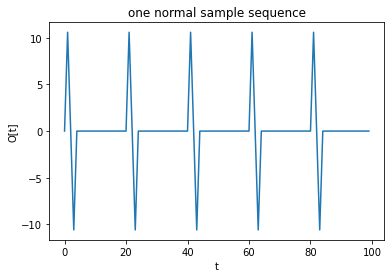

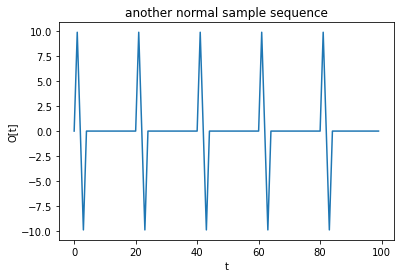

In [27]:
# training (normal) set demo
plt.plot(dataTrain[0 : sequenceLen])
plt.title('one normal sample sequence')
plt.xlabel('t')
plt.ylabel('O[t]')
plt.show()
plt.plot(dataTrain[8 * sequenceLen : 9 * sequenceLen])
plt.title('another normal sample sequence')
plt.xlabel('t')
plt.ylabel('O[t]')
plt.show()

In [28]:
# generate the normal testing set
normalTest = np.array([])
normalTestLen = np.zeros((nSequencesNormalTest,), dtype = 'int')
for i in range(nSequencesNormalTest):
    peak = np.random.normal(loc = peakMean, scale = peakSD, size = 1)
    for j in range(sequenceLen):
        if j % period == positivePeakID:
            observation = peak
        elif j % period == negativePeakID:
            observation = - peak
        else:
            observation = noBeatPos
        normalTest = np.append(normalTest, observation)
    normalTestLen[i] = int(sequenceLen)
        
# generate one anomaly testing set
# this anomaly set sometimes has a different period
anomalyTest = np.array([])
anomalyTestLen = np.zeros((nSequencesAnomalyTest,), dtype = 'int')
nAnomaly = 1 # number of times that the heart suddenly jumps
magicCnt = 3
positiveMagicID = 6
negativeMagicID = 8
for i in range(nSequencesAnomalyTest):
    peak = np.random.normal(loc = peakMean, scale = peakSD, size = 1)
    magicCnt = 3
    for j in range(sequenceLen):
        if j % period == positivePeakID: # normal beat
            observation = peak
            magicCnt = magicCnt - 1
        elif j % period == negativePeakID: # normal beat
            observation = - peak
        else:
            if magicCnt <= 0 and magicCnt > - nAnomaly:
                # magic influences the patient's heart!
                if j % period == positiveMagicID:
                    observation = peak
                elif j % period == negativeMagicID:
                    observation = - peak
                else:
                    observation = 0
            else:
                # beats normally
                observation = 0
        anomalyTest = np.append(anomalyTest, observation)
    anomalyTestLen[i] = int(sequenceLen)

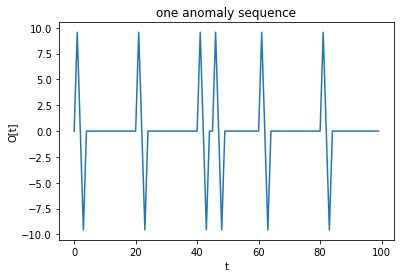

In [29]:
# anomaly set demo
plt.plot(anomalyTest[0 : sequenceLen])
plt.title('one anomaly sequence')
plt.xlabel('t')
plt.ylabel('O[t]')
plt.show()

In [31]:
# define the model and initialize

# model parameters
nComponents = 3
model = hmm.GaussianHMM(n_components = nComponents,
                        covariance_type = "full")

In [32]:
# train the model using only the normal dataset
dataFit = dataTrain.reshape(-1, 1)
model.fit(dataFit, dataTrainLen)

GaussianHMM(covariance_type='full', n_components=3)

In [33]:
# test the model

# use the normal test set
scoreNormal = np.empty((nSequencesNormalTest, ))
for i in range(nSequencesNormalTest):
    dataScore = normalTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreNormal[i] = model.score(dataScore)

# use the anomaly test set
scoreAnomaly = np.empty((nSequencesAnomalyTest, ))
for i in range(nSequencesAnomalyTest):
    dataScore = anomalyTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreAnomaly[i] = model.score(dataScore)

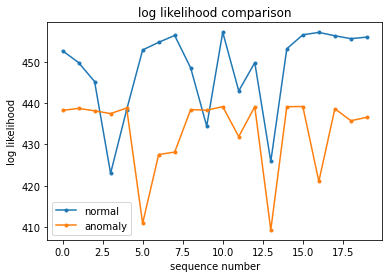

In [34]:
# plot the testing result
plt.plot(scoreNormal, ".-", label = 'normal')
plt.plot(scoreAnomaly, ".-", label = 'anomaly')
plt.legend()
plt.title('log likelihood comparison')
plt.xlabel('sequence number')
plt.ylabel('log likelihood')
plt.show()

In [35]:
# generate one special normal set
# this set has a different none beating value

# synthetic parameters
nSequencesSpecial = 20
noBeatPosSpecial = - 0.5

specialTest = np.array([])
specialTestLen = np.zeros((nSequencesSpecial,), dtype = 'int')
for i in range(nSequencesSpecial):
    peak = np.random.normal(loc = peakMean, scale = peakSD,
                            size = 1)
    for j in range(sequenceLen):
        if j % period == positivePeakID:
            observation = noBeatPosSpecial + peak
        elif j % period == negativePeakID:
            observation = noBeatPosSpecial - peak
        else:
            observation = noBeatPosSpecial
        specialTest = np.append(specialTest, observation)
    specialTestLen[i] = sequenceLen

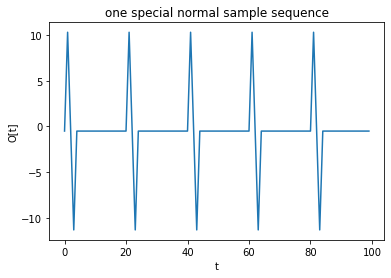

In [10]:
# special set demo
plt.plot(specialTest[0 : sequenceLen])
plt.title('one special normal sample sequence')
plt.xlabel('t')
plt.ylabel('O[t]')
plt.show()

In [192]:
# test the model

# use the normal test set
scoreNormal = np.empty((nSequencesNormalTest, ))
for i in range(nSequencesNormalTest):
    dataScore = normalTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreNormal[i] = model.score(dataScore)

# use the anomaly test set
scoreAnomaly = np.empty((nSequencesAnomalyTest, ))
for i in range(nSequencesAnomalyTest):
    dataScore = anomalyTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreAnomaly[i] = model.score(dataScore)
    
# use the special normal test set
scoreSpecial = np.empty((nSequencesSpecial, ))
for i in range(nSequencesSpecial):
    dataScore = specialTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreSpecial[i] = model.score(dataScore)

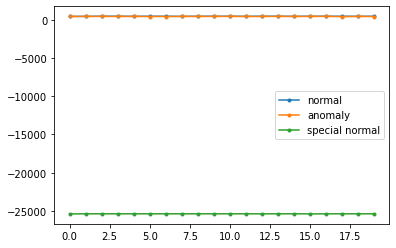

In [193]:
# plot the testing result
plt.plot(scoreNormal, ".-", label = 'normal')
plt.plot(scoreAnomaly, ".-", label = 'anomaly')
plt.plot(scoreSpecial, ".-", label = 'special normal')
plt.legend()
plt.show()

In [40]:
# define another model and initialize

# model parameters
nComponents = 10
modelSpec = hmm.GaussianHMM(n_components = nComponents,
                        covariance_type = "full")

In [41]:
# train the model using both the normal dataset
# and the special normal dataset
dataFit = np.append(dataTrain, specialTest)
dataFitLen = np.append(dataTrainLen, specialTestLen)
dataFit = dataFit.reshape(-1, 1)
modelSpec.fit(dataFit, dataFitLen)

GaussianHMM(covariance_type='full', n_components=10)

In [42]:
# test the special model

# use the normal test set
scoreNormal = np.empty((nSequencesNormalTest, ))
for i in range(nSequencesNormalTest):
    dataScore = normalTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreNormal[i] = modelSpec.score(dataScore)

# use the anomaly test set
scoreAnomaly = np.empty((nSequencesAnomalyTest, ))
for i in range(nSequencesAnomalyTest):
    dataScore = anomalyTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreAnomaly[i] = modelSpec.score(dataScore)
    
# use the special normal test set
scoreSpecial = np.empty((nSequencesSpecial, ))
for i in range(nSequencesSpecial):
    dataScore = specialTest[i * sequenceLen : (i + 1) * sequenceLen].reshape(-1, 1)
    scoreSpecial[i] = modelSpec.score(dataScore)

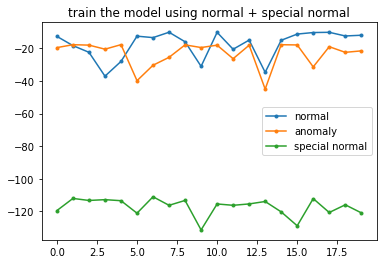

In [43]:
# plot the testing result
plt.plot(scoreNormal, ".-", label = 'normal')
plt.plot(scoreAnomaly, ".-", label = 'anomaly')
plt.plot(scoreSpecial, ".-", label = 'special normal')
plt.legend()
plt.title('train the model using normal + special normal')
plt.show()